In [ ]:
!pip install torch pytorch_lightning
import warnings
warnings.filterwarnings('ignore')
import os
import time
import math
import pandas as pd
import numpy as np
from PIL import Image
import torch
from torch import nn
import torch.nn.functional as F 
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
import pytorch_lightning as pl
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

In [2]:
from google.colab import drive
drive.mount('/content/drive')
root_dir = '/content/drive/MyDrive/StockPricePrediction/'

Mounted at /content/drive


In [3]:
# FUSION DATASETS
class FusionDataset(object):
    def __init__(self, df, history_len, step_len, dir_path, transforms):
        self.dir_path = dir_path
        self.transforms = transforms
        df_imgs_path = pd.read_csv(dir_path + 'Target.csv')
        self.imgs = df_imgs_path.filename.tolist()
        self.history_len = history_len
        self.step_len = step_len

        df['close_log'] = np.log(df['Close'] / df['Close'].shift(1))
        df['target_log'] = np.log(df['Close'].shift(-step_len) / df['Close'])
        history = []
        target = [] 
        for i in range(history_len, df.shape[0]-step_len):
            history.append(df[i-history_len+1: i]['close_log'].values)
            target.append(df.loc[i-1, 'target_log'])
        history, target = np.array(history), np.array(target)
        history = np.reshape(history, (history.shape[0], history.shape[1], 1))
        self.history = history
        self.target = target

    def __getitem__(self, idx):
        history = torch.tensor(self.history[idx], dtype=torch.float)
        # Load images
        img_path = os.path.join(self.dir_path, self.imgs[idx])
        img = Image.open(img_path).convert('RGB')
        target = torch.tensor([self.target[idx]], dtype=torch.float)

        if self.transforms is not None:
            img = self.transforms(img)

        return history, img, target

    def __len__(self):
        return self.history.shape[0]

In [4]:
# FUSION DATA MODULE
class FusionDataModule(pl.LightningDataModule):
    def __init__(self, df, history_len, step_len):
        super(FusionDataModule, self).__init__()
        self.df = df
        self.history_len = history_len
        self.step_len = step_len
        
    def setup(self, stage):
        # Train/val/test split
        length = self.df.shape[0]
        train_df = self.df[:2100].copy()
        train_df.reset_index(inplace=True)
        val_df = self.df[2100:2410].copy()
        val_df.reset_index(inplace=True)
        test_df = self.df[2410:].copy()
        test_df.reset_index(inplace=True)
        # transforms for images
        transform=transforms.Compose([transforms.ToTensor(), 
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

        self.train = FusionDataset(train_df, self.history_len, self.step_len,
                                   root_dir + 'DataAI/Train/',
                                       transforms=transform)
        self.val = FusionDataset(val_df, self.history_len, self.step_len,
                                     root_dir + 'DataAI/Val/',
                                     transforms=transform)
        self.test = FusionDataset(test_df, self.history_len, self.step_len,
                                      root_dir + 'DataAI/Test/',
                                      transforms=transform)
        
    def train_dataloader(self):
        return DataLoader(self.train, batch_size=64)

    def val_dataloader(self):
        return DataLoader(self.val, batch_size=64)
    
    def test_dataloader(self):
        return DataLoader(self.test, batch_size=64)

In [5]:
# RESIDUAL BLOCK
class ResidualBlock(nn.Module):
    def __init__(self, num_channels, output_channels, stride1, stride2, stride3, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        self.cond = any([stride1 != 1, stride2 != 1, stride3 != 1])
        self.conv1 = nn.Conv2d(num_channels, num_channels, padding=1, 
                            kernel_size=3, stride=stride1)
        self.batch_norm = nn.BatchNorm2d(num_channels)
        self.conv2 = nn.Conv2d(num_channels, num_channels, padding=1, 
                            kernel_size=3, stride=stride2)
        if self.cond:
            self.conv = nn.Conv2d(num_channels, num_channels, padding=0,
                                kernel_size=1, stride=max(stride1, stride2, stride3))
        # Last convolutional layer to reduce output block shape.
        self.conv3 = nn.Conv2d(num_channels, output_channels, padding=0, 
                            kernel_size=1, stride=stride3)
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, X):
        if self.cond:
            Y = self.conv(X)
        else:
            Y = X
        X = self.conv1(X)
        X = self.batch_norm(X)
        X = self.relu(X)
        X = self.conv2(X)
        X = self.batch_norm(X)
        X = self.relu(X+Y)
        X = self.conv3(X)
        return X

In [6]:
class FusionLSTM_CNN_3loss(pl.LightningModule):
    def __init__(self):
        super(FusionLSTM_CNN_3loss, self).__init__()
        p = dict(
            history_len = 30,
            step_len = 5,
            seq_len = 29,
            batch_size = 128, 
            criterion = nn.MSELoss(),
            max_epochs = 15,
            n_features = 1,
            hidden_size = 50,
            num_layers = 1,
            dropout = 0.8,
            learning_rate = 0.01
        )
        self.n_features = p['n_features']
        self.hidden_size = p['hidden_size']
        self.seq_len = p['seq_len']
        self.batch_size = p['batch_size']
        self.num_layers = p['num_layers']
        self.dropout = p['dropout']
        self.criterion = p['criterion']
        self.learning_rate = p['learning_rate']
        # LSTM feature
        self.lstm_feature = nn.LSTM(input_size=p['n_features'],
                                    hidden_size=p['hidden_size'],
                                    num_layers=p['num_layers'],
                                    dropout=p['dropout'],
                                    batch_first=True)
        # CNN feature
        self.cnn_feature = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            ResidualBlock(
                num_channels=32, output_channels=128,
                stride1=1, stride2=1, stride3=1),
            ResidualBlock(
                num_channels=128, output_channels=256,
                stride1=2, stride2=1, stride3=1),
            ResidualBlock(
                num_channels=256, output_channels=512,
                stride1=2, stride2=1, stride3=1),
            nn.AvgPool2d(kernel_size=7, padding=0),
            nn.LayerNorm([512, 1, 1])
        )
        # LSTM-CNN FC
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(in_features=562, out_features=500)
        self.fc2 = nn.Linear(in_features=500, out_features=100)
        self.fc3 = nn.Linear(in_features=100, out_features=25)
        self.out = nn.Linear(in_features=25, out_features=1)
        
    def forward(self, x1, x2):
        # LSTM 
        x1, _ = self.lstm_feature(x1)
        x1 = x1[:,-1]
        # CNN 
        x2 = self.cnn_feature(x2)
        x2 = x2.view(x2.size(0), -1)
        # Fusion model
        fusion_out = torch.cat((x1, x2), 1)
        fusion_out = self.fc1(fusion_out)
        fusion_out = self.dropout(fusion_out)
        fusion_out = self.fc2(fusion_out)
        fusion_out = self.dropout(fusion_out)
        fusion_out = self.fc3(fusion_out)
        fusion_out = self.dropout(fusion_out)
        fusion_out = self.out(fusion_out)
        
        return fusion_out
    
    def training_step(self, batch, batch_idx):
        x1, x2, target = batch
        logits_fusion = self.forward(x1, x2)
        loss = F.mse_loss(logits_fusion, target)
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x1, x2, target = batch
        logits_fusion = self.forward(x1, x2)
        loss = F.mse_loss(logits_fusion, target)
        self.log('val_loss', loss)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=0.01, momentum=0.9)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, patience=2, verbose=True, min_lr=1e-5
        )
        return {'optimizer': optimizer, 'lr_scheduler': scheduler, 'monitor': 'val_loss'}

In [ ]:
 # TRAINER

"""df = pd.read_csv(root_dir + 'data/dji_2009-2019.csv')
data_module = FusionDataModule(df, 30, 5)
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor='val_loss',
    dirpath=root_dir + 'Model',
    filename='dji-scheduler-{epoch:02d}-{val_loss:.9f}',
    save_top_k=5,
    mode='min',
)
trainer = pl.Trainer(
    max_epochs=150,
    callbacks=[checkpoint_callback]
)
model = FusionLSTM_CNN_3loss()
trainer.fit(model, data_module) """

In [13]:
def plot_price(model, df, path, setname):
    # Get predictions
    transform=transforms.Compose([transforms.ToTensor(),
                                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    dataset = FusionDataset(df,30,5,root_dir + path,transforms=transform)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=False, num_workers=2)
    predictions = None
    for i, batch in enumerate(dataloader):
        print(i, end='\r')
        X,Y,Z = batch
        output = model(X,Y)
        if predictions is None:
            predictions = output.detach().numpy()
        else:
            predictions = np.row_stack([predictions, output.detach().numpy()])
    # Get target price
    seq_length = 30
    step_length = 5
    df['target_log'] = np.log(df['Close'].shift(-step_length) / df['Close'])
    length = df.shape[0]
    target_price = df[seq_length+step_length:df.shape[0]]['Close']
    inv = df[seq_length:df.shape[0]-step_length]['Close'].values.reshape(-1, 1)
    predicted_price = inv * (np.exp(1) ** predictions)

    # Visualising the results
    date = df[seq_length+step_length:df.shape[0]].Date.values
    plt.figure(figsize=(20,10))
    plt.plot(date, target_price, color = 'red', label = 'Target Price')
    plt.plot(date, predicted_price, color = 'blue', label = 'Predicted Price')
    plt.xticks(np.arange(0,len(predicted_price),100))
    plt.title(setname )
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()
    print(f'RMSE: {mean_squared_error(target_price, predicted_price, squared=False)}')
    print(f'MAPE: {mean_absolute_percentage_error(target_price, predicted_price)}')
    print(f'MAE: {mean_absolute_error(target_price, predicted_price)}')

In [8]:
    df = pd.read_csv(root_dir + 'dji_2009-2019.csv')
    length =df.shape[0]
    train_df =df[:2100].copy()
    train_df.reset_index(inplace=True)
    val_df = df[2100:2410].copy()
    val_df.reset_index(inplace=True)
    test_df = df[2410:].copy()
    test_df.reset_index(inplace=True)

In [9]:
checkpoint = '/content/drive/MyDrive/StockPricePrediction/Model/dji-scheduler-epoch=149-val_loss=0.000301939.ckpt'
model = FusionLSTM_CNN_3loss.load_from_checkpoint(checkpoint)

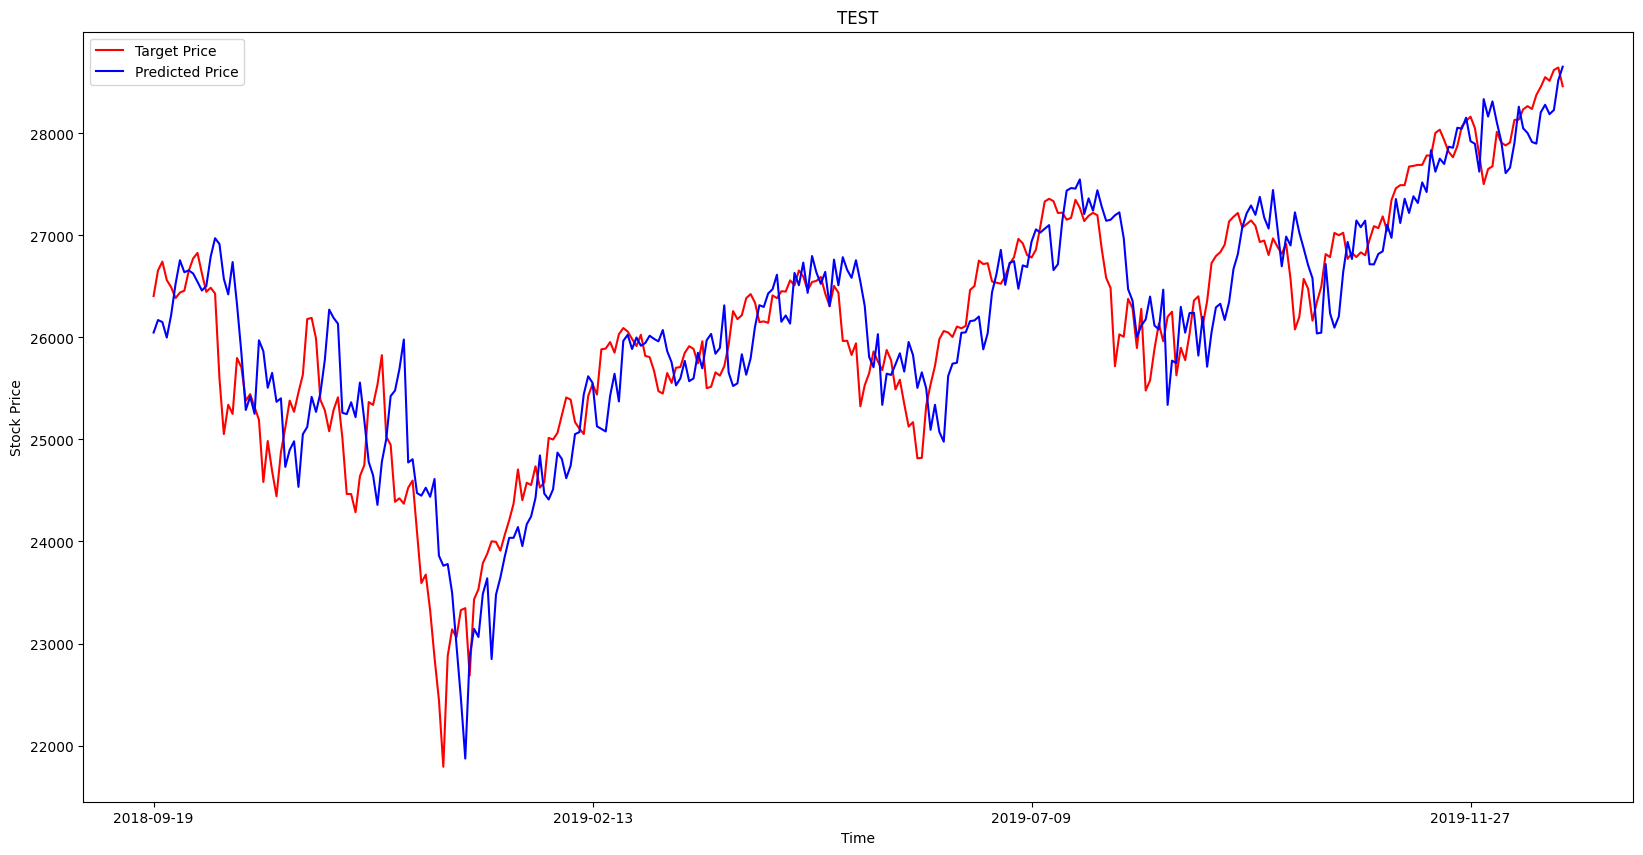

RMSE: 547.8530551370335
MAPE: 0.016421894080254282
MAE: 420.4138276934182


In [15]:
plot_price(model, test_df, 'DataAI/Test/', 'TEST')